In [2]:

import uproot
file_path = r"C:\Users\Agastya\OneDrive\Desktop\train_rooot_file.root"  # change if needed
file = uproot.open(file_path)

print(file.keys())  # Shows available trees
  



['deepntuplizer;1', 'deepntuplizer/tree;42', 'deepntuplizer/tree;41']


In [3]:
tree = file["deepntuplizer/tree;42"]

In [61]:


for name in tree.keys():
    print(name)



Delta_gen_pt
event_no
gen_pt
isB
isBB
isC
isG
isLeptonicB
isLeptonicB_C
isS
isUD
isUndefined
jet_corr_pt
jet_eta
jet_looseId
jet_no
jet_phi
jet_pt
jet_tightId
npv
ntrueInt
pfBoostedDoubleSecondaryVertexAK8BJetTags
pfCombinedInclusiveSecondaryVertexV2BJetTags
pfCombinedMVAV2BJetTags
pfDeepCSVJetTags_probb
pfDeepCSVJetTags_probbb
pfDeepCSVJetTags_probc
pfDeepCSVJetTags_probcc
pfDeepCSVJetTags_probudsg
pfJetBProbabilityBJetTags
pfJetProbabilityBJetTags
rho
softPFElectronBJetTags
softPFMuonBJetTags
fj_doubleb
fj_eta
fj_gen_eta
fj_gen_pt
fj_isBB
fj_isH
fj_isNonBB
fj_isQCD
fj_isTop
fj_isW
fj_isZ
fj_jetNTracks
fj_label
fj_labelJMAR
fj_labelLegacy
fj_mass
fj_nSV
fj_n_sdsubjets
fj_nbHadrons
fj_ncHadrons
fj_phi
fj_pt
fj_ptDR
fj_relptdiff
fj_sdmass
fj_sdn2
fj_sdsj1_axis1
fj_sdsj1_axis2
fj_sdsj1_csv
fj_sdsj1_eta
fj_sdsj1_mass
fj_sdsj1_mult
fj_sdsj1_phi
fj_sdsj1_pt
fj_sdsj1_ptD
fj_sdsj2_axis1
fj_sdsj2_axis2
fj_sdsj2_csv
fj_sdsj2_eta
fj_sdsj2_mass
fj_sdsj2_mult
fj_sdsj2_phi
fj_sdsj2_pt
fj_sdsj2_ptD


In [1]:
import pandas as pd


tree = file["deepntuplizer/tree;42"]

scalar_branches = [
    # Jet kinematics
    "fj_pt", "fj_eta", "fj_phi", "fj_mass",
    "fj_sdmass", "fj_tau1", "fj_tau2", "fj_tau21",
    "rho", "npv",

    # Labels
    "label_QCD_bb", "label_QCD_c", "label_QCD_others",
    "label_H_bb", "label_Top_bq", "label_Z_bb"
]

df = tree.arrays(scalar_branches, library="pd")
print(df.head())
print(df.shape)


NameError: name 'file' is not defined

In [ ]:
import numpy as np
import awkward as ak

tree = file["deepntuplizer/tree;42"]

# Selecting relevant branches
jet_branches = [
    "fj_pt", "fj_eta", "fj_phi", "fj_mass",
    "fj_sdmass", "fj_tau1", "fj_tau2", "fj_tau21",
    "npv", "rho"
]

track_branches = [
    "track_ptrel",
    "track_deltaR",
    "track_mass",
    "track_normchi2"
]

label_branch = "fj_isBB"

# Load data
jets = tree.arrays(jet_branches, library="ak")
tracks = tree.arrays(track_branches, library="ak")
labels = tree[label_branch].array(library="ak")

print("Loaded:")
print(jets.type)
print(tracks.type)
print(labels.type)


Loaded:
200000 * {fj_pt: float32, fj_eta: float32, fj_phi: float32, fj_mass: float32, fj_sdmass: float32, fj_tau1: float32, fj_tau2: float32, fj_tau21: float32, npv: float32, rho: float32}
200000 * {track_ptrel: var * float32, track_deltaR: var * float32, track_mass: var * float32, track_normchi2: var * float32}
200000 * int32


In [92]:
jet_features = ak.to_numpy(jets)
labels_np = ak.to_numpy(labels)


In [93]:
max_tracks = 30

# Convert awkward array to numpy and pad
track_features = []
for i in range(len(labels_np)):
    # Get all features for current event
    event_tracks = []
    for branch in track_branches:
        event_tracks.append(ak.to_numpy(tracks[branch][i]))
    
    # Stack features for current event
    if len(event_tracks[0]) > 0:  # Check if there are any tracks
        event_array = np.stack(event_tracks, axis=1)
    else:
        event_array = np.zeros((0, len(track_branches)))
    
    # Pad or truncate to max_tracks
    if event_array.shape[0] > max_tracks:
        event_array = event_array[:max_tracks]
    else:
        padding = ((0, max_tracks - event_array.shape[0]), (0, 0))
        event_array = np.pad(event_array, padding, mode='constant')
    
    track_features.append(event_array)

track_features = np.stack(track_features)


In [117]:

features = df.drop(columns=["is_Higgs"])
labels = df["is_Higgs"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

df_scaled = pd.DataFrame(X_scaled, columns=features.columns)
df_scaled["is_Higgs"] = labels.values

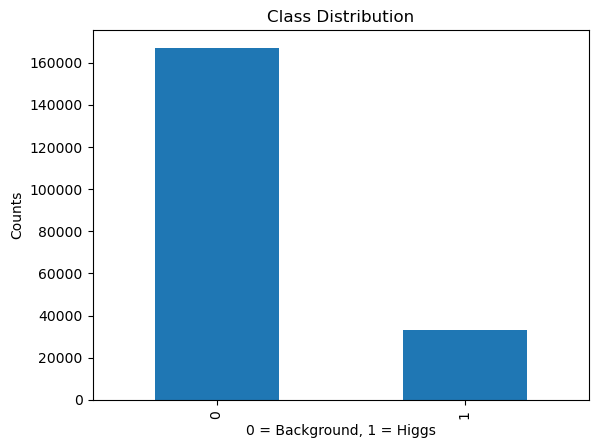

In [106]:
import matplotlib.pyplot as plt

df_scaled["is_Higgs"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("0 = Background, 1 = Higgs")
plt.ylabel("Counts")
plt.show()


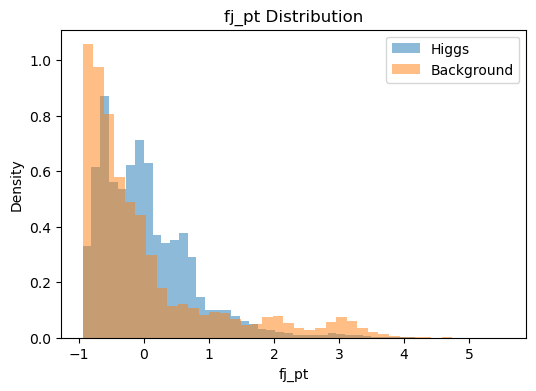

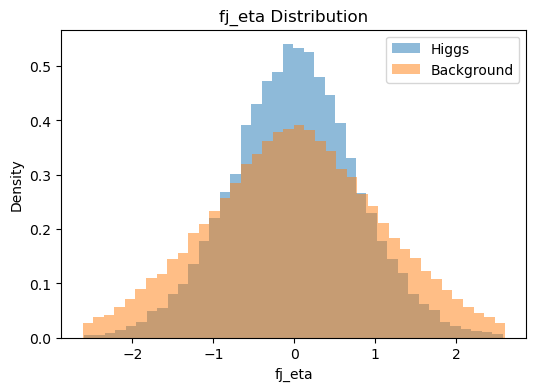

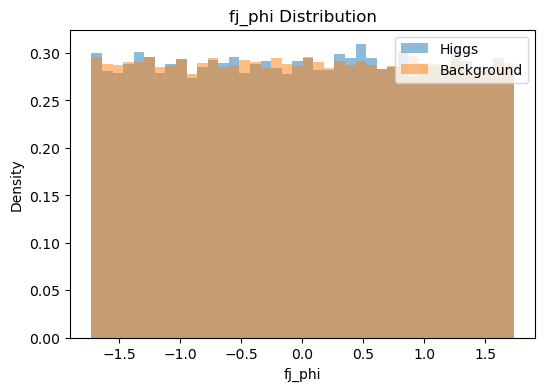

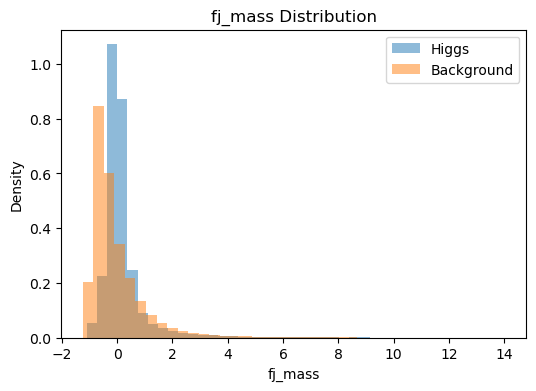

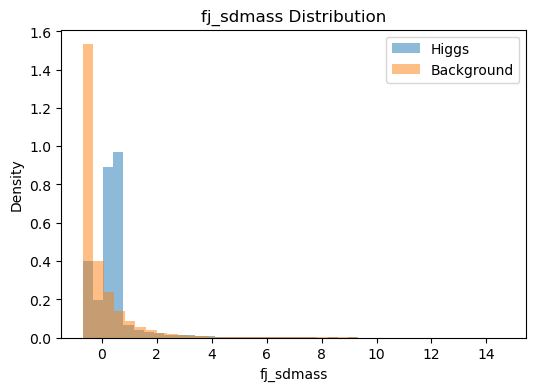

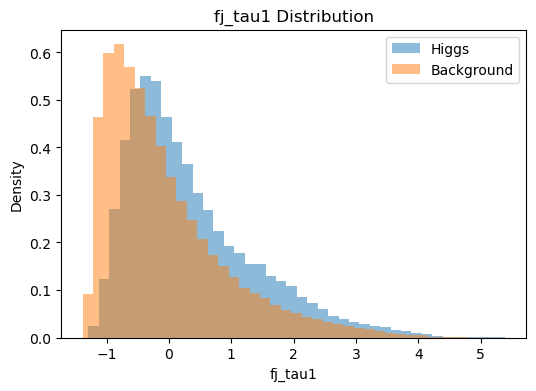

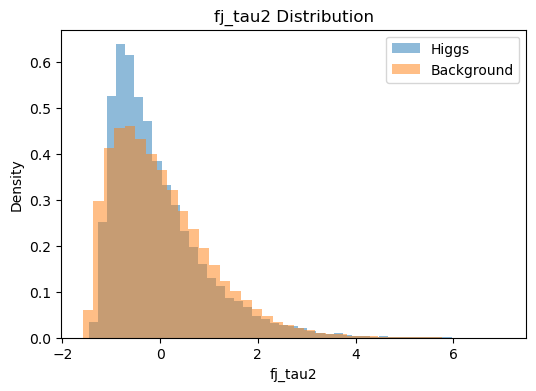

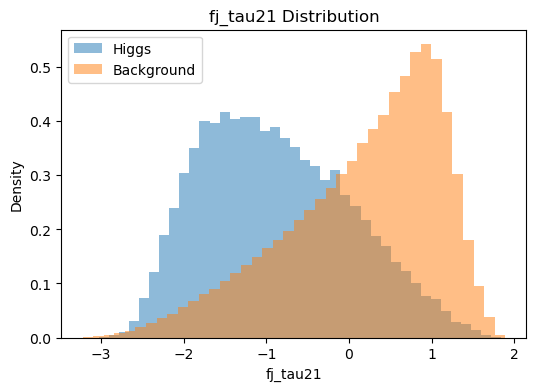

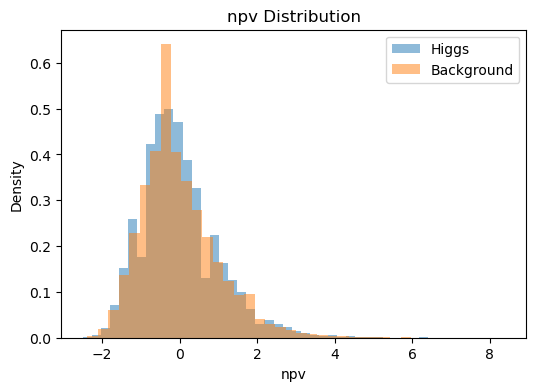

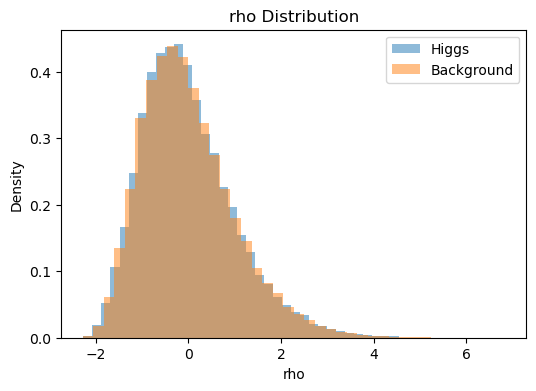

In [118]:
sig = df_scaled[df_scaled.is_Higgs == 1]
bkg = df_scaled[df_scaled.is_Higgs == 0]

for col in features.columns:
    plt.figure(figsize=(6,4))
    plt.hist(sig[col], bins=40, alpha=0.5, label="Higgs", density=True)
    plt.hist(bkg[col], bins=40, alpha=0.5, label="Background", density=True)
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


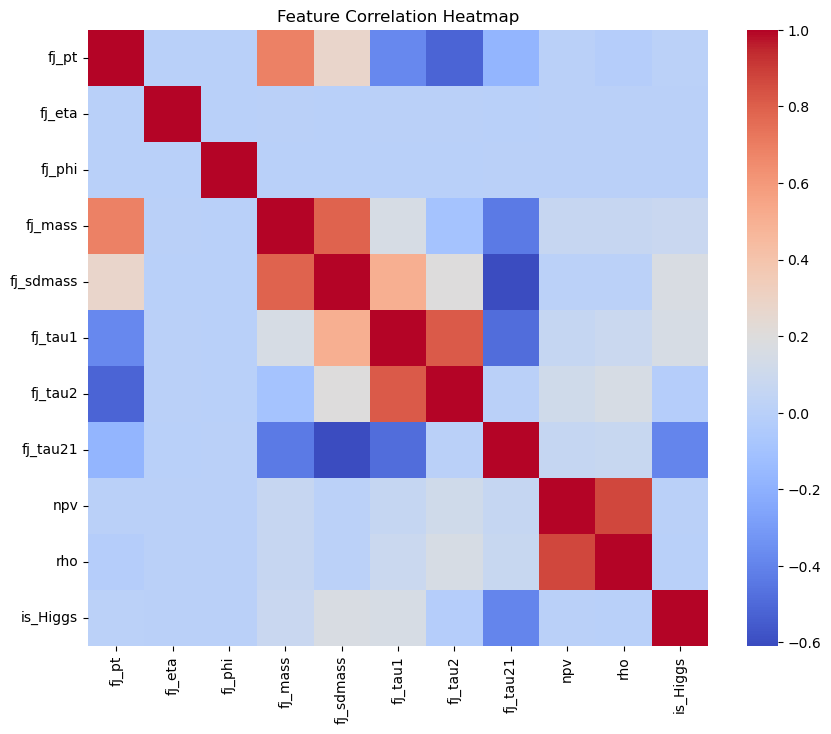

In [108]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


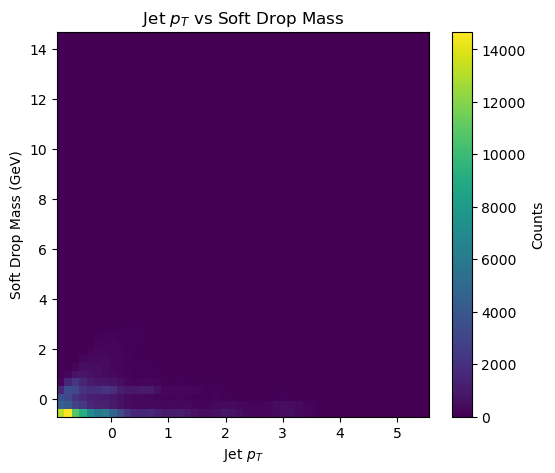

In [109]:
plt.figure(figsize=(6,5))
plt.hist2d(df_scaled["fj_pt"], df_scaled["fj_sdmass"], bins=50, cmap="viridis")
plt.colorbar(label="Counts")
plt.xlabel("Jet $p_T$")
plt.ylabel("Soft Drop Mass (GeV)")
plt.title("Jet $p_T$ vs Soft Drop Mass")
plt.show()


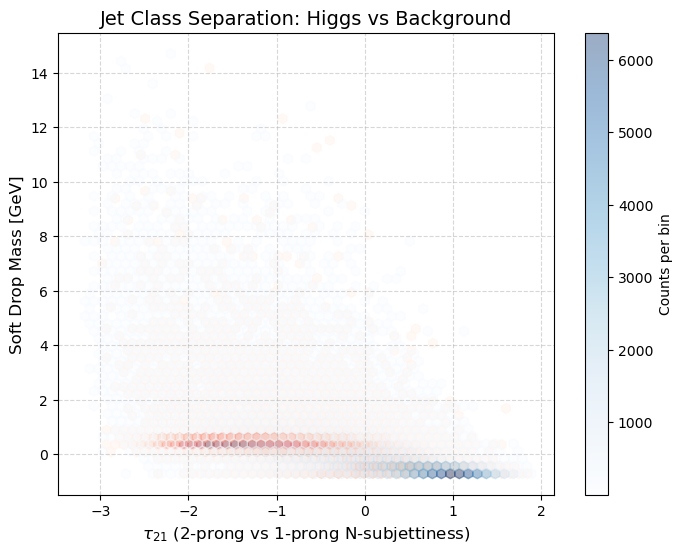

In [119]:
plt.figure(figsize=(8,6))

# Higgs_jets_density
plt.hexbin(
    df_scaled[df_scaled.is_Higgs==1]["fj_tau21"],
    df_scaled[df_scaled.is_Higgs==1]["fj_sdmass"],
    gridsize=50,
    cmap="Reds",
    alpha=0.6,
    mincnt=1,
    label="Higgs Jets"
)

# Background_jets_density
plt.hexbin(
    df_scaled[df_scaled.is_Higgs==0]["fj_tau21"],
    df_scaled[df_scaled.is_Higgs==0]["fj_sdmass"],
    gridsize=50,
    cmap="Blues",
    alpha=0.4,
    mincnt=1,
    label="Background Jets"
)

plt.xlabel(r"$\tau_{21}$ (2-prong vs 1-prong N-subjettiness)", fontsize=12)
plt.ylabel("Soft Drop Mass [GeV]", fontsize=12)
plt.title("Jet Class Separation: Higgs vs Background", fontsize=14)

# Add_colorbars
cbar = plt.colorbar()
cbar.set_label("Counts per bin")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
C:\Users\Agastya\AppData\Local\Temp\ipykernel_12364\2342556800.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


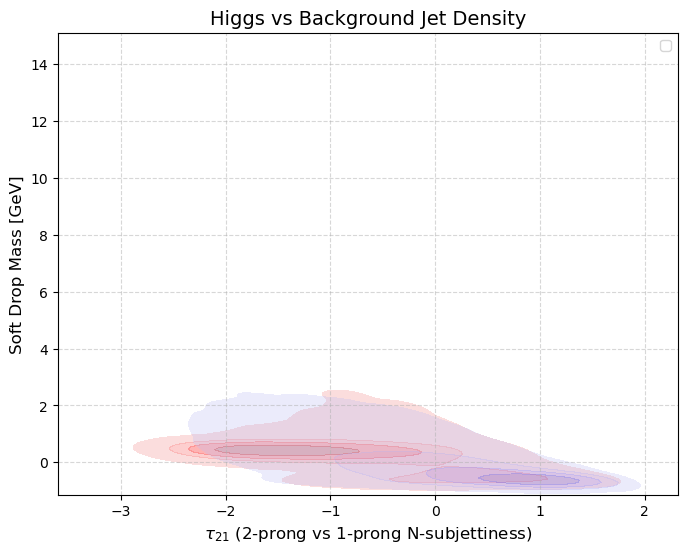

In [ ]:


# Separate_signal_and_background
sig = df_scaled[df_scaled.is_Higgs == 1]
bkg = df_scaled[df_scaled.is_Higgs == 0]

plt.figure(figsize=(8,6))

# Higgs_jets_density_contour
sns.kdeplot(
    x=sig["fj_tau21"],
    y=sig["fj_sdmass"],
    levels=5,
    color="red",
    linewidths=1.5,
    label="Higgs Jets",
    fill=True,
    alpha=0.4
)

# Background_jets_density_contour
sns.kdeplot(
    x=bkg["fj_tau21"],
    y=bkg["fj_sdmass"],
    levels=5,
    color="blue",
    linewidths=1.5,
    label="Background Jets",
    fill=True,
    alpha=0.3
)

# Axis labels
plt.xlabel(r"$\tau_{21}$ (2-prong vs 1-prong N-subjettiness)", fontsize=12)
plt.ylabel("Soft Drop Mass [GeV]", fontsize=12)

# Title and legend
plt.title("Higgs vs Background Jet Density", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()



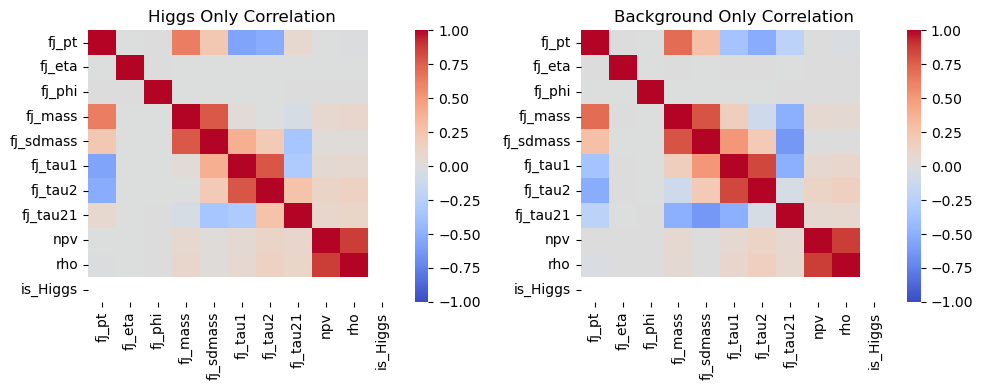

In [120]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(sig.corr(), vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Higgs Only Correlation")

plt.subplot(1,2,2)
sns.heatmap(bkg.corr(), vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Background Only Correlation")

plt.tight_layout()
plt.show()
